In [1]:
import nltk,re,time,umap,collections,os,string,sys,mlflow
sys.path.append(os.path.abspath(".."))
from modules import utils,modeling

from sentence_transformers import SentenceTransformer
import plotly.express as px
import pandas as pd

from sklearn.metrics import completeness_score,homogeneity_score, v_measure_score,normalized_mutual_info_score,adjusted_mutual_info_score,silhouette_score
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np

from sklearn.preprocessing import OneHotEncoder
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
from hdbscan import HDBSCAN
from sentence_transformers import models
from sklearn.preprocessing import normalize
from transformers import AutoModel, AutoTokenizer
from torch import nn
import mlflow.sklearn
from  mlflow.tracking import MlflowClient
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
onehotencoder = OneHotEncoder(handle_unknown='ignore')


client = MlflowClient()

#tokenizer = AutoTokenizer.from_pretrained("dbmdz/bert-base-german-cased")


%matplotlib inline
%load_ext autoreload
%autoreload 2

%reload_ext utils
%reload_ext modeling
os.environ["MLFLOW_S3_ENDPOINT_URL"]="http://s3.eu-central-1.amazonaws.com"
os.environ["MLFLOW_TRACKING_USERNAME"]="mlflow"
os.environ["MLFLOW_TRACKING_PASSWORD"]="mlflow"

## Read the data

In [13]:
df= utils.load_text_data("topic_thunder_input_bild-short.csv").head(2000)
df.created_at = pd.to_datetime(df.created_at,utc=True)
df= df[(df.created_at < q.timestamp.max()) & (df.created_at > q.timestamp.min())]

def replace_seo_title(row):
    if  type(row['seo_title']) == float or str(row['seo_title'])=='':
        #print(row['seo_title']row['title'])
        row['seo_title']= row['headline']
        row['seo_title_NER']= row['kicker_headline_NER']
    row['seo_title'] = str(row['seo_title'])
    return row

df =df.apply(replace_seo_title,axis=1)

In [14]:
df.shape

(1168, 10)

In [15]:
df['_text'] = df['seo_title'].apply(lambda x: utils.remove_seo_title_marker(x,False)) +". "+ df["text"]
pdf = utils.preprocess_articles_for_bert(df,"_text",lower=False)
_pdf = pd.DataFrame(pdf,index=df.index)

In [16]:
model_name= "T-Systems-onsite/bert-german-dbmdz-uncased-sentence-stsb"
word_embedding_model = models.Transformer(model_name,max_seq_length=512)   
embeddings,sbert_model = modeling.get_sentence_embeddings(pdf,word_embedding_model,False,True)
embeddings


--- Embedding dimension 768
--- 1168 Documnets encoded 1142.1628606319427 seconds ---


array([[ 0.22367132, -0.4259254 , -0.07394557, ..., -0.29952797,
        -0.30445763, -0.25339302],
       [ 0.5722194 , -0.54803324, -0.6038588 , ..., -0.4059095 ,
        -0.38429275, -0.5276737 ],
       [-0.6235966 , -0.7368279 ,  0.45148778, ..., -0.59753007,
        -0.63540477, -0.4860956 ],
       ...,
       [ 0.6635227 , -0.49689052,  0.22038618, ..., -0.35250458,
        -0.46913928, -0.28224826],
       [-0.06789626, -0.08244615,  0.17228521, ..., -0.18260328,
        -0.45043284, -1.1340595 ],
       [ 0.3248545 , -0.4399696 ,  0.24319428, ...,  0.59915143,
        -1.3607725 , -0.1816477 ]], dtype=float32)

In [166]:
#results,cluster_labels = modeling.cluster_and_reduce(embeddings=embeddings,n_components_clustering=16 ,min_cluster_size=3,n_neighbors=3, min_samples= 3,alpha=1.0,cluster_selection_method='eom')


#embeddings = embeddings.astype(np.float64)
reduced_embeddings=modeling._new_umap_reduce(embeddings,    args = {"n_neighbors":5, "n_components": 128, 'min_dist':0.1, "metric": 'cosine', "random_state": 0})
viz_embeddings = modeling._new_umap_reduce(embeddings,    args = {"n_neighbors":5, "n_components": 2, 'min_dist':0.1, "metric": 'cosine', "random_state": 0})





--- UMAP fitted in 8.843270063400269 seconds 
--- Reduced dimensionality to (1168, 128) .
--- UMAP fitted in 3.52797794342041 seconds 
--- Reduced dimensionality to (1168, 2) .


In [167]:

dep_one_hot=onehotencoder.fit_transform(np.vstack(df.department.values)).toarray()

#reduced_embeddings=np.concatenate((reduced_embeddings,dep_one_hot),axis=1)

In [168]:
cluster_labels = modeling.cluster(reduced_embeddings,min_cluster_size=3, min_samples=2,
              alpha=1.0, metric='euclidean',cluster_selection_method= 'leaf',approx_min_span_tree= True)

>> --- Done in 0.2 seconds ---
>> Silhouette Coefficient: 0.46489450335502625


In [169]:
docs_df = utils.relink_data_after_clustering(viz_embeddings,df,cluster_labels)
docs_df["department"]=df.department.values

Outlier points: 149 | Clustered: 1019 (0.872431506849315) | Cluster count: 190 


In [170]:
docs_df.head(2)

,x,y,topic_number,headline,seo_title,raw_text,article_uid,kicker_headline_ne,text_ne,seo_title_ne,created_at,department
0,10.594807,3.849231,83,Muss ich die staatlichen Hilfen zurückzahlen?,Muss ich die staatlichen Hilfen zurückzahlen?,Gerade die Selbstständigen traf es im Lockdown...,2a6347f1d256415b6abf58eb70b097f7a6204151e3bf08...,"[{""entities"":[{""mentions"":[{""text"":{""content"":...","[{""entities"":[{""mentions"":[{""text"":{""content"":...","[{""entities"":[{""mentions"":[{""text"":{""content"":...",2021-04-02,ratgeber
1,12.670773,1.774709,33,Fachwerk-Anbau abgefackelt,Fachwerk-Anbau abgefackelt,Coppenbrügge (Niedersachsen) – Feuerwehr-Große...,26c7a8ee7693a650bdbbd438c043c434a9e937e9f55d65...,"[{""entities"":[{""mentions"":[{""text"":{""content"":...","[{""entities"":[{""mentions"":[{""text"":{""content"":...","[{""entities"":[{""mentions"":[{""text"":{""content"":...",2021-04-02,regional


In [171]:

# For every topic collect all the article and join their texts (preprocessed) , raw texts, 
docs_per_topic = docs_df.groupby(['topic_number'], as_index = False).agg({
                                                                   "seo_title_ne":lambda x: (utils.flatten([utils.parse_google_named_entities(el) for el in x ])),
                                                                    "kicker_headline_ne":lambda x: (utils.flatten([utils.parse_google_named_entities(el) for el in x ])),
                                                                      "text_ne":lambda x: (utils.flatten([utils.parse_google_named_entities(el) for el in x ])),
                                                                  })


docs_per_topic=docs_per_topic.set_index("topic_number")#.kicker_headline[0]

In [172]:
ctrs=[]
stopwords = list(utils.load_stopwords())
for topic in docs_per_topic.index.values: # Go over topic labels 
    
    generic_ent_obj = {'type':'COMMON'}
    
    text_ne_arr = [ dict(generic_ent_obj, **obj) for obj in docs_per_topic.loc[topic]["text_ne"]]
    seo_title_arr = [ dict(generic_ent_obj, **obj) for obj in docs_per_topic.loc[topic]["seo_title_ne"]]
    kicker_headline_ne_arr = [ dict(generic_ent_obj, **obj) for obj in docs_per_topic.loc[topic]["kicker_headline_ne"]]
    text_entities = [elem['text'] for 
                         elem in text_ne_arr
                             if not elem['type'] =="NUMBER" and not elem['type'] =="COMMON" and (not elem['text'].lower())  in stopwords]
    seo_title_entities = [elem["text"] 
                          for elem in seo_title_arr
                              if (not elem['type'] =="NUMBER") and not elem['type'] =="COMMON" and (not elem['text'].lower()  in stopwords)] 
    kicker_headline_entities = [elem["text"]  for elem in kicker_headline_ne_arr
                                    if (not elem['type'] =="NUMBER") and (not elem['type'] =="COMMON") and elem['text'].lower() not in stopwords ] 
    
    counted_word_occurances = collections.Counter(seo_title_entities+kicker_headline_entities).most_common()[:8]

    #counted_word_occurances = collections.Counter([elem["text"] for elem in docs_per_topic.set_index("Topic").loc[topic]["text_ne"] if not elem['type'] =="NUMBER" and not elem['type'] =="COMMON"]).most_common()[:10]
    ctrs.append(counted_word_occurances)
dict_with_top_words = {k:v  for k,v in  zip(docs_per_topic.index.values,ctrs)}    


cluster_labels_google = pd.DataFrame(zip(docs_per_topic.index.values,[" | ".join([word[0] for word in word_score]) for word_score in ctrs]),columns=["Topic","TopWords"]).sort_values(by="Topic").set_index("Topic")

Number of stopwords 607


In [173]:
results =pd.merge(docs_df[['x', 'y', 'topic_number', 'headline', 'seo_title', 'raw_text',
       'article_uid', 
       'created_at', 'department']],cluster_labels_google.reset_index(),left_on="topic_number",right_on='Topic')

In [174]:
cluster_labels_google.TopWords.unique()[:10]

array(['Corona | Polizei | Auto | Impfung | HSV | AstraZeneca | Werder Bremen | Deutschland',
       'Wetter | Sonne | Ostern | Bayern | Eier-Suche | Regen | Sonnenschein | Oster-Wetter',
       'Ever Given | Suezkanal | Blockade | Containerschiff | Lieferengpässe | Fisch | Corona | Frosta',
       'DFB | Kritik | Präsident | Keller | Nationalspieler-Sitzung | Jogi-Team | Botschaft | Vergabe',
       'Bahrain | Formel 1 | Hamilton | MotoGP | Schumacher | Mick | Formel-1 | Rennen',
       'NBA | Star | Frust | Lakers | Überraschungs-Transfer | Debüt | Bulls | Theis',
       'Bußgeld | Ärger | SPD | ZAG | Erfurt | Schlange | Hofpfisterei | Berliner',
       'Inzidenz | München | Corona | Neuinfektionen | Thüringen | Corona-Bestimmungen | Notbremse | Brandenburg',
       'Kind | Opfern | Schüssen | Los Angeles | Schießerei | Washington | Kohlenmonoxid-Vergiftung | Duisburg',
       'Prozess | Floyd | Minneapolis | Gericht | Gewalt | Welle | Tablettenabhängigkeit | Freundin'],
      dtype=

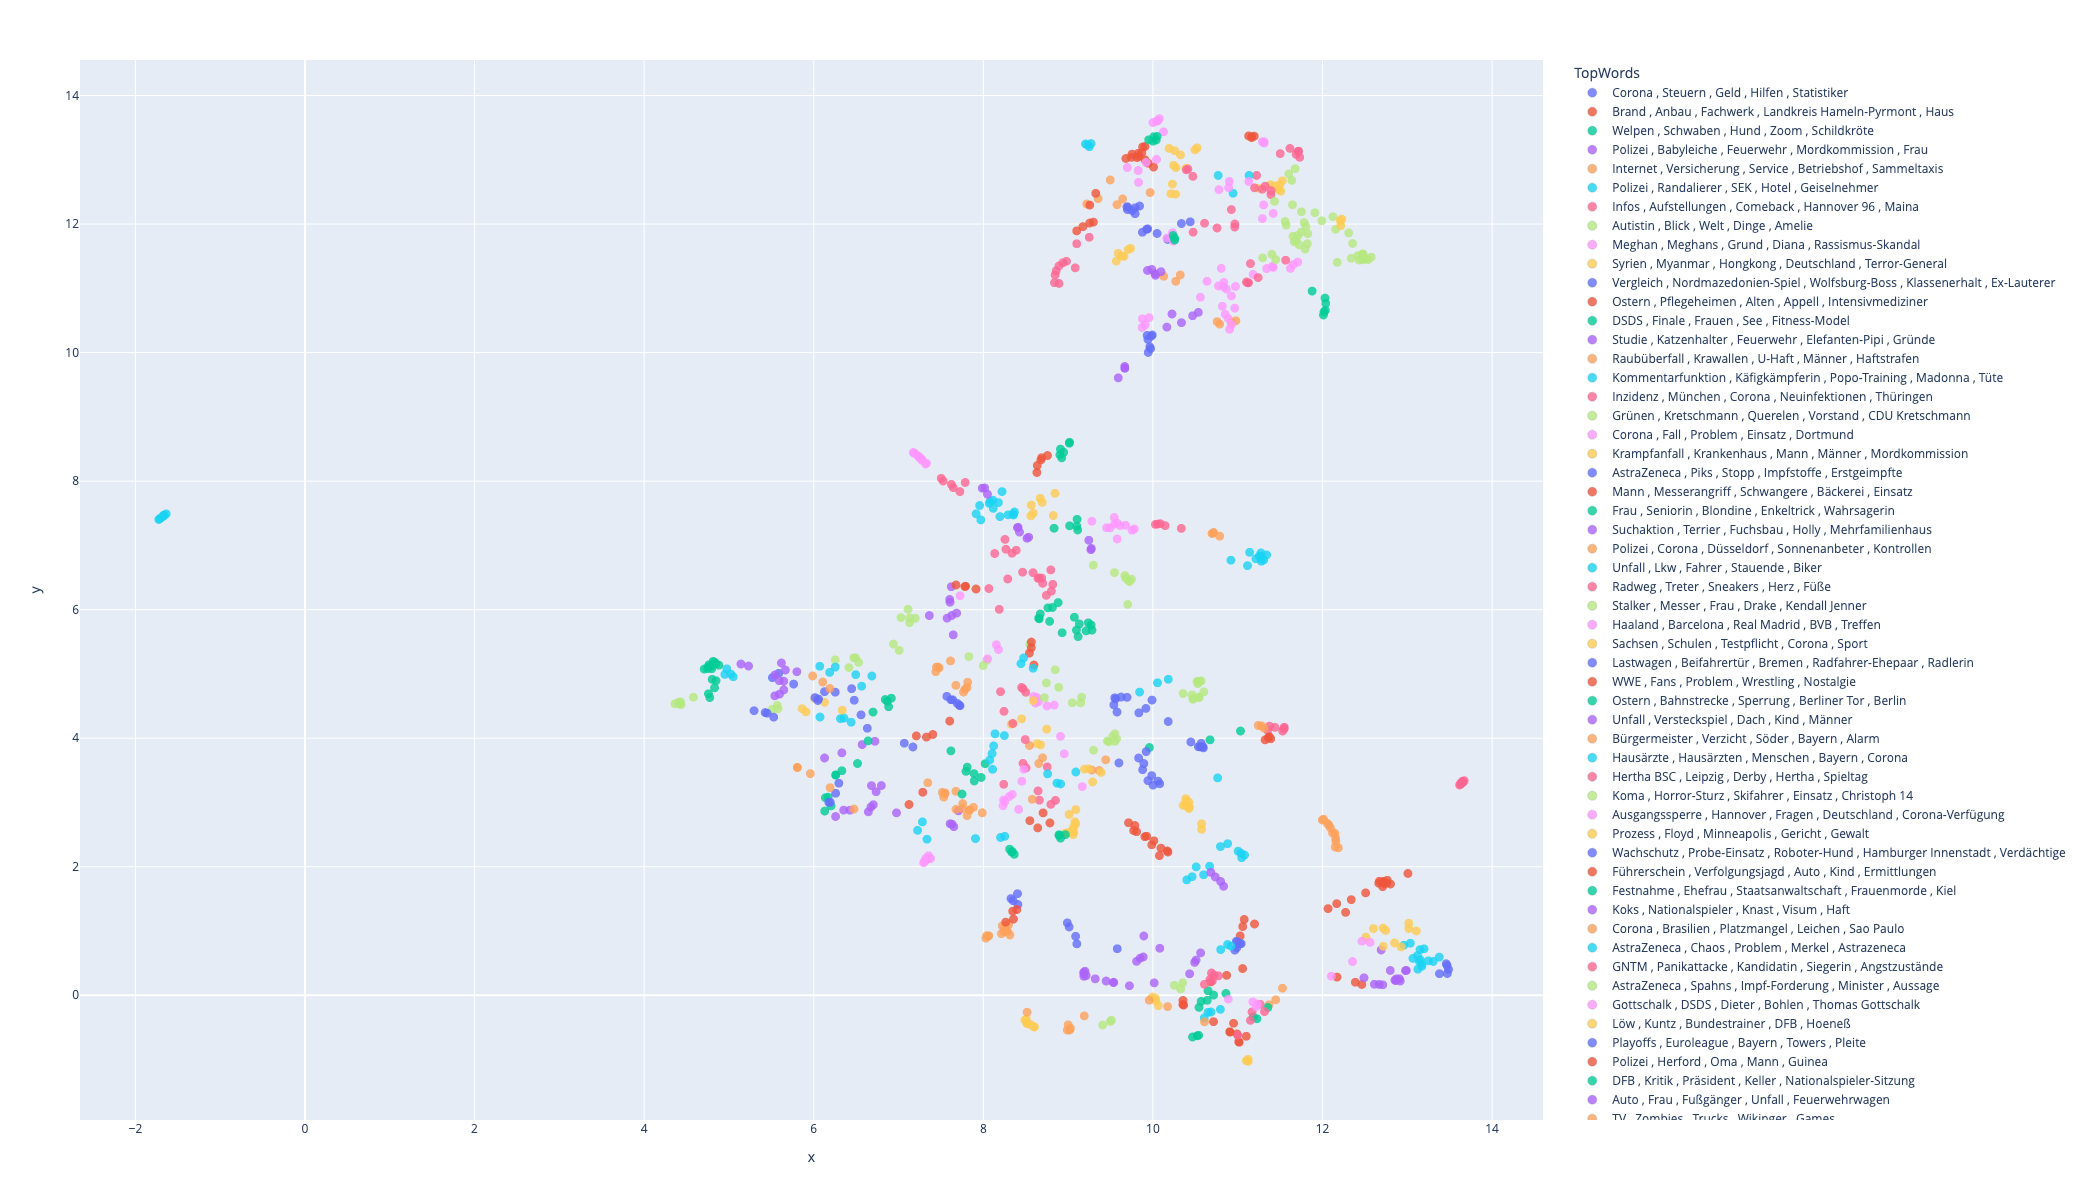

In [189]:

results.topic_number=results.topic_number.apply(str)
RESULTS = results[results.topic_number != "-1"].copy()
RESULTS.TopWords = RESULTS.TopWords.apply(lambda x:  ",".join(x.split("|")[:5]))
fig = px.scatter(RESULTS, x="x", y="y", hover_name="seo_title", hover_data=["created_at","topic_number","TopWords"], color="TopWords",opacity=0.8)

fig.update_traces(marker=dict(size=9, line=dict(width=0.15,color='DarkSlateGrey')), selector=dict(mode='markers'))
fig["layout"].pop("updatemenus")

fig.update_layout(height=1200)
fig.write_html("./techday1.html")
fig.show()   

In [165]:
topic_sizes=results.groupby("topic_number").count().sort_values(by='Topic',ascending=True).reset_index()[["topic_number","article_uid"]]

res_with_sizes = pd.merge(results, topic_sizes,on="topic_number").rename(columns={'article_uid_y':"topic_size","article_uid_x":"article_uid"})
res = pd.merge(res_with_sizes,df.reset_index()[["cms_id","is_premium","article_uid"]],on="article_uid",suffixes=("","_"))[['x','y','topic_number','headline','seo_title','article_uid','cms_id','created_at','department',"TopWords",'topic_size',"is_premium"]]
res

,x,y,topic_number,headline,seo_title,article_uid,cms_id,created_at,department,TopWords,topic_size,is_premium
0,12.658997,-0.075072,13,Muss ich die staatlichen Hilfen zurückzahlen?,Muss ich die staatlichen Hilfen zurückzahlen?,2a6347f1d256415b6abf58eb70b097f7a6204151e3bf08...,75755832,2021-04-02,ratgeber,Corona | Steuern | Geld | Hilfen | Statistiker...,9,1
1,12.647555,0.151929,13,"Liebe, Geld, Fußball – Erfolg lässt sich berec...","Statistiker: Liebe, Geld, Fußball – Erfolg läs...",f36fb69d9293d645aaf2cfa8a0f2e5cead50a41377fc57...,75887884,2021-04-01,ratgeber,Corona | Steuern | Geld | Hilfen | Statistiker...,9,1
2,12.611057,0.212540,13,Ständig perfekt sein? Bloß nicht!,Ständig perfekt sein? Bloß nicht!,ce49ab75f3b0de5dfc7ca4fccca80f254549075ae96747...,75749956,2021-03-31,ratgeber,Corona | Steuern | Geld | Hilfen | Statistiker...,9,1
3,12.774993,-0.066854,13,Muss ich Steuern nachzahlen?,Muss ich Steuern nachzahlen?,e4222c5bba2110a859ac4ae05153c4c039dfc975b9b24a...,75825714,2021-03-31,ratgeber,Corona | Steuern | Geld | Hilfen | Statistiker...,9,1
4,12.415775,-0.141736,13,6750 Tickets gespendet,6750 Tickets gespendet,a2314525317ba3aa2df4fec48f996bef53cde4aae7775a...,75910620,2021-03-31,regional,Corona | Steuern | Geld | Hilfen | Statistiker...,9,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1163,17.229956,5.076126,99,Bijol darf nicht nach Hannover,Hannover 96: Länderspiel-Wirbel! Jaka Bijol da...,6a2427c4022c76efc55e680e45b3db094c63f69461b262...,75890866,2021-03-28,sport,Schluss | Hannover | Selbstvertrauen | Juwel |...,3,1
1164,17.402395,5.025876,99,Diesem Juwel droht jetzt das Bayern-Aus,FC Bayern: Bank-Frust statt Selbstvertrauen! D...,1c36a09e35ec117cf8789c41d4eecd264c1d5756782edc...,75890942,2021-03-28,sport,Schluss | Hannover | Selbstvertrauen | Juwel |...,3,1
1165,3.539421,-0.215199,120,Junge (12) kentert mit Surfbrett auf Bostalsee,Großeinsatz: Junge (12) kentert mit Surfbrett ...,b1cd68f8f3f4a53dd3df87e206964d775b52db549354b4...,75893110,2021-03-28,regional,Großeinsatz | Junge | Surfbrett | Bostalsee | ...,3,0
1166,3.508647,-0.258336,120,Angler (80) stirbt nach Bootsunfall vor Rügen,Rügen: Motorboot gekentert! Angler (80) stirbt...,a49060e531397a3a78e62dbb24474df681ccfb8e675dab...,75892178,2021-03-28,news,Großeinsatz | Junge | Surfbrett | Bostalsee | ...,3,0
